In [1]:
import scipy, h5py
import numpy as np
import matplotlib.pyplot as plt

from dca import DynamicalComponentsAnalysis as DCA, style
from dca.cov_util import calc_cross_cov_mats_from_data
from dca.synth_data import embedded_lorenz_cross_cov_mats, gen_lorenz_data, random_basis, median_subspace
from dca.plotting.fig1 import lorenz_fig_axes, plot_3d, plot_lorenz_3d, plot_traces, plot_dca_demo, plot_r2, plot_cov

RESULTS_FILENAME = "lorenz_results.hdf5"

# Only need to run this cell once

In [2]:
#Set parameters
T = 4
N = 30
noise_dim = 7
snr_vals = np.logspace(-2, 2, 20)

#Save params
with h5py.File(RESULTS_FILENAME, "w") as f:
    f.attrs["T"] = T
    f.attrs["N"] = N
    f.attrs["noise_dim"] = noise_dim
    f.attrs["snr_vals"] = snr_vals

    #Generate Lorenz dynamics
    num_samples = 10000
    X_dynamics = gen_lorenz_data(num_samples)
    dynamics_var = np.max(scipy.linalg.eigvalsh(np.cov(X_dynamics.T)))

    #Save dynamics
    f.create_dataset("X_dynamics", data=X_dynamics)
    f.attrs["dynamics_var"] = dynamics_var

    #Generate dynamics embedding matrix (will remain fixed)
    np.random.seed(42)
    V_dynamics = random_basis(N, 3, np.random)
    X = np.dot(X_dynamics, V_dynamics.T)

    #Generate a subspace with median principal angles w.r.t. dynamics subspace
    V_noise = median_subspace(N, noise_dim, num_samples=5000, V_0=V_dynamics, rng=np.random)
    #... and extend V_noise to a basis for R^N
    V_noise_comp = scipy.linalg.orth(np.eye(N) - np.dot(V_noise, V_noise.T))
    V_noise = np.concatenate((V_noise, V_noise_comp), axis=1)

    #Save embeded dynamics and embedding matrices
    f.create_dataset("X", data=X)
    f.attrs["V_dynamics"] = V_dynamics
    f.attrs["V_noise"] = V_noise

    #To-save: noisy data, reconstructed PCA, reconstructed DCA
    X_noisy_dset = f.create_dataset("X_noisy", (len(snr_vals), num_samples, N))
    X_pca_trans_dset = f.create_dataset("X_pca_trans", (len(snr_vals), num_samples, 3))
    X_dca_trans_dset = f.create_dataset("X_dca_trans", (len(snr_vals), num_samples, 3))

    #Loop over SNR vals
    for snr_idx in range(len(snr_vals)):
        snr = snr_vals[snr_idx]
        print("snr =", snr)
        
        _, X_noisy = embedded_lorenz_cross_cov_mats(N, T, snr, noise_dim, return_samples=True,
                                                    V_dynamics=V_dynamics, V_noise=V_noise,
                                                    X_dynamics=X_dynamics)
        X_noisy = X_noisy - X_noisy.mean(axis=0)
        #Save noisy data
        X_noisy_dset[snr_idx] = X_noisy

        #Run DCA
        opt = DCA(T=T, d=3)
        opt.fit(X_noisy)
        V_dca = opt.coef_

        #Run PCA
        V_pca = scipy.linalg.eigh(np.cov(X_noisy.T))[1][:, ::-1][:, :3]

        #Project data onto DCA and PCA bases
        X_dca = np.dot(X_noisy, V_dca)
        X_pca = np.dot(X_noisy, V_pca)

        #Linearly trasnform projected data to be close to original Lorenz attractor
        beta_pca = np.linalg.lstsq(X_pca, X_dynamics, rcond=None)[0]
        beta_dca = np.linalg.lstsq(X_dca, X_dynamics, rcond=None)[0]
        X_pca_trans = np.dot(X_pca, beta_pca)
        X_dca_trans = np.dot(X_dca, beta_dca)

        #Save transformed projections
        X_pca_trans_dset[snr_idx] = X_pca_trans
        X_dca_trans_dset[snr_idx] = X_dca_trans

snr = 0.01
snr = 0.016237767391887217
snr = 0.026366508987303583
snr = 0.04281332398719394
snr = 0.06951927961775606
snr = 0.11288378916846889
snr = 0.18329807108324356
snr = 0.29763514416313175
snr = 0.4832930238571752
snr = 0.7847599703514611
snr = 1.2742749857031335
snr = 2.06913808111479
snr = 3.359818286283781
snr = 5.455594781168514
snr = 8.858667904100823
snr = 14.38449888287663
snr = 23.357214690901213
snr = 37.92690190732246
snr = 61.584821106602604
snr = 100.0


# Load data and plot

In [2]:
with h5py.File(RESULTS_FILENAME, "r") as f:
    snr_vals = f.attrs["snr_vals"][:]
    X = f["X"][:]
    X_noisy_dset = f["X_noisy"][:]
    X_pca_trans_dset = f["X_pca_trans"][:]
    X_dca_trans_dset = f["X_dca_trans"][:]
    X_dynamics = f["X_dynamics"][:]

    r2_vals = np.zeros((len(snr_vals), 2))
    for snr_idx in range(len(snr_vals)):
        X_pca_trans = X_pca_trans_dset[snr_idx]
        X_dca_trans = X_dca_trans_dset[snr_idx]
        r2_pca = 1 - np.sum((X_pca_trans - X_dynamics)**2)/np.sum((X_dynamics - np.mean(X_dynamics, axis=0))**2)
        r2_dca = 1 - np.sum((X_dca_trans - X_dynamics)**2)/np.sum((X_dynamics - np.mean(X_dynamics, axis=0))**2)
        r2_vals[snr_idx] = [r2_pca, r2_dca]

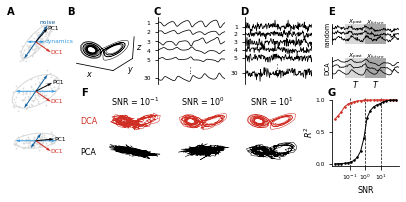

In [3]:
#Create axes
axes, txt_cords = lorenz_fig_axes(fig_width=5.5,
                                  wpad_edge=0.01, wpad_mid=0.05,
                                  left_ax_width=0.125, left_ax_wpad=0.025,
                                  hpad_bottom=0.132, hpad_top=0.06, hpad_mid=0.075)
left_ax_1, left_ax_2, left_ax_3, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12 = axes
linewidth_3d = 0.5
linewidth_2d = 0.75
linewidth_r2_plot = 1.0

#colors = ["#3E884C", "#523176", "#CF2F25"]
#colors = ["green", "purple", "#CF2F25"]
noise_color = "#1261A0"
sig_color = "#3B9CDD"
past_color = "0.85"
future_color = "0.65"
dca_color = "#CF2F25"
pca_color = "black"

T_to_show_2d = 150
T_to_show_3d = 500
X_display_idx = 8 #index of noisy X dataset to show (make sure to change if SNR spacing changes)

#ax1: Lorenz 3D Plot
plot_lorenz_3d(ax1, X_dynamics[:T_to_show_3d], linewidth_3d)

#ax2 and ax3: Plots of noiseless and noisy embeddings
N_to_show = 5 #number of channels to plot (also plot last one)
plot_traces(ax2, X[:T_to_show_2d], N_to_show, linewidth_2d)
#divide by a factor to make it look better
plot_traces(ax3, X_noisy_dset[X_display_idx, :T_to_show_2d]/1.8, N_to_show, linewidth_2d)

#ax4 and ax5: Plots of projections (DCA and random)
#get a random projection of X_noisy and transorm for Lorenz comparison
to_proj = X_noisy_dset[X_display_idx]
np.random.seed(42)
X_random = np.dot(to_proj, scipy.stats.ortho_group.rvs(to_proj.shape[1])[:, :3])
beta_random = np.linalg.lstsq(X_random, X_dynamics, rcond=None)[0]
X_random_trans = np.dot(X_random, beta_random)
plot_dca_demo(ax4, ax5, X_random_trans[:T_to_show_2d], X_dca_trans_dset[X_display_idx, :T_to_show_2d],
              past_color=past_color, future_color=future_color, linewidth=linewidth_2d)

#Plot Lorenz panels
dca_axes = [ax6, ax8, ax10]
pca_axes = [ax7, ax9, ax11]
plt_snr_vals = [0.1, 1.0, 10.0]
plt_snr_strs = ["$10^{-1}$", "$10^{0}$", "$10^{1}$"]
plt_idx = [np.argmin((snr_vals-snr)**2) for snr in plt_snr_vals]
for i in range(3):
    plot_3d(X_dca_trans_dset[plt_idx[i], :T_to_show_3d], ax=dca_axes[i], color=dca_color, linewidth=linewidth_3d)
    plot_3d(X_pca_trans_dset[plt_idx[i], :T_to_show_3d], ax=pca_axes[i], color=pca_color, linewidth=linewidth_3d)
    dca_axes[i].set_title("SNR = " + plt_snr_strs[i], pad=5, fontsize=style.axis_label_fontsize)
for ax in dca_axes + pca_axes:
    ax.set_axis_off()
    ax.dist = 7.5
plt.gcf().text(txt_cords[0][0], txt_cords[0][1], "DCA", va="center", ha="center", fontsize=style.axis_label_fontsize, color=dca_color)
plt.gcf().text(txt_cords[1][0], txt_cords[1][1], "PCA", va="center", ha="center", fontsize=style.axis_label_fontsize, color=pca_color)

#Finally, the R2 vs SNR plot
plot_r2(ax12, snr_vals, plt_snr_vals, r2_vals, dca_color, pca_color)

#Left cov plots
left_ax_1.set_zorder(1000)
plot_cov(left_ax_1, sig_var=1, noise_var=5, noise_sig_labels=True, noise_color=noise_color, sig_color=sig_color, pca_color=pca_color, dca_color=dca_color)
plot_cov(left_ax_2, sig_var=5, noise_var=5, noise_sig_labels=False, noise_color=noise_color, sig_color=sig_color, pca_color=pca_color, dca_color=dca_color)
plot_cov(left_ax_3, sig_var=5, noise_var=1, noise_sig_labels=False, noise_color=noise_color, sig_color=sig_color, pca_color=pca_color, dca_color=dca_color)

plt.savefig("fig1.pdf")